let us start by importing the required functions

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
# from ema_workbench.connectors import vensimDLLwrapper
# from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Adding Reconversion Open Exploration  

In [2]:
vensimModel = VensimModel("SelectPolicy", model_file="PolicyforObjectives_Step6_Full Policies_adaptive_AffordabilityFocus_Solution35.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("Average Fertility Rate", 0.01, 0.025),
            RealParameter("Average Mortality Rate", 0.00126, 0.00154),
            IntegerParameter("BASE Average Household size", 2, 7),
#             RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.4),     
            RealParameter("average Immigration percent", 0.01, 0.06),
            RealParameter("Housing Area Per person", 0.000004, 0.000006),
            RealParameter("Floor Area Ratio", 2, 7),
            RealParameter("Average Residential approval period", 0.5, 2),
            RealParameter("Base Green Area commisioned per year", 0.02, 0.06),
            RealParameter("average green area construction period", 0.5, 2),
            RealParameter("Base Economic area Conversion rate", 0.01, 0.06),
            RealParameter("Base Slum reconversion rate", 0.01, 0.06),
            RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.5),
            RealParameter("house construction time", 0.5, 2),
            IntegerParameter("time delay effect uncertainty of spending capacity on housing price", 1, 4),
            RealParameter("Slum dwelling area per person", 0.000004, 0.000006),
            RealParameter("Base residential conversion rate", 0.01, 0.05),
            RealParameter("average Emmigration percent", 0.008, 0.05),
            RealParameter("Relocation Rate", 0.001, 0.02), #for relocation of population on streets
            RealParameter("Average Commercial Approval Period", 0.5, 2),
            RealParameter("Base Green Area Reconversion rate", 0.001, 0.03),
            RealParameter("Average Slum Construction period", 0.1, 0.5),
            RealParameter("Average slum Demolition Period", 0.5, 2),
            RealParameter("uncertainty of average percent of inflation effect", 0.01, 0.08),
            RealParameter("average payment to income ratio for housing", 0.2, 0.5),
            RealParameter("Base Non Economic Reconv rate", 0.01 ,0.05),
            RealParameter("Ratio of Renting to Buying",0.2, 1),
            RealParameter("margin of empty housing",0.1,0.5)
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Housing Affordability Rating'),
    TimeSeriesOutcome('People with No Settlements'),
    TimeSeriesOutcome('Illegal Slum Population'),
    TimeSeriesOutcome('Urban Non Residential Area'),
    TimeSeriesOutcome('Urban Residential Land'),
    TimeSeriesOutcome('Slum Area'),
    TimeSeriesOutcome('Green Area')
    
]


In [4]:
results2 = perform_experiments(vensimModel, scenarios=1500, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './Step7Policy_vulnerability.tar.gz'
save_results(results2, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Papers\V2\Step7Policy_vulnerability.tar.gz


In [8]:
results2 = load_results('./Step7Policy_vulnerability.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Papers\V2\Step7Policy_vulnerability.tar.gz


In [3]:
import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE
import ema_workbench.analysis.pairs_plotting as pairs
import ema_workbench.analysis.plotting as emaplt


In [4]:
plt.rcParams["figure.figsize"] = (10,40)

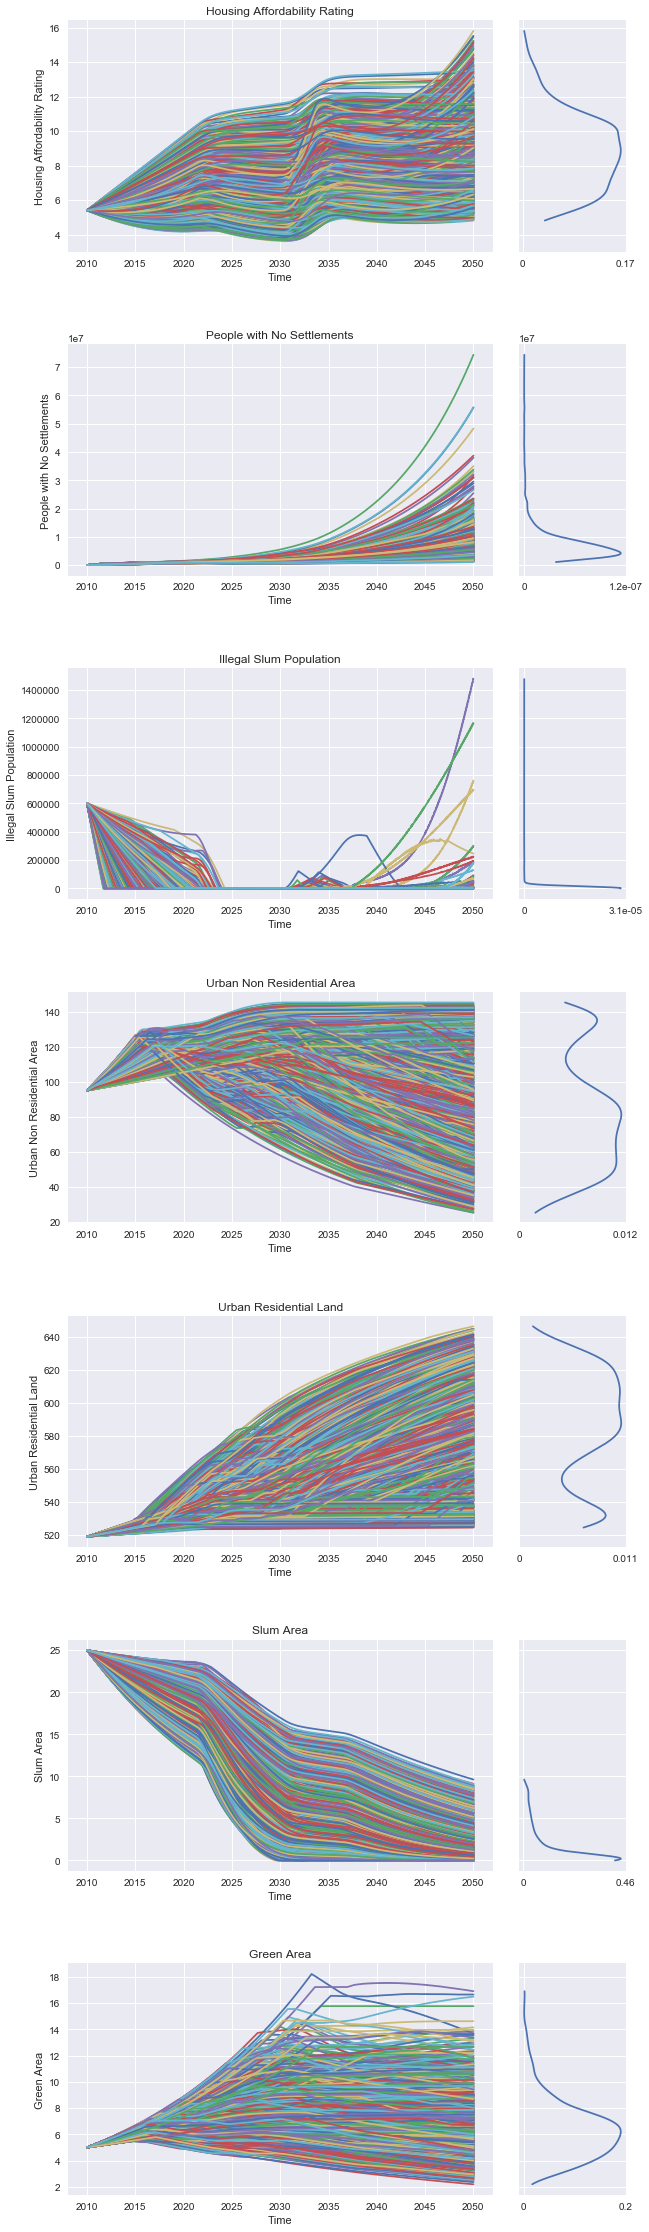

In [5]:
figure = emaplt.lines(results2, density=u'kde') #show lines, and end state density
# plt.rcParams["figure.figsize"] = (15,30)
plt.show()

In [10]:
experiments, outcomes = results2

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Housing Affordability Rating'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>7] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 894 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.414, coverage: 0.6946308724832215, density: 1.0 restricted_dimensions: 1


In [17]:
box_1.show_tradeoff()
mpld3.display()

TypeError: Object of type 'ndarray' is not JSON serializable

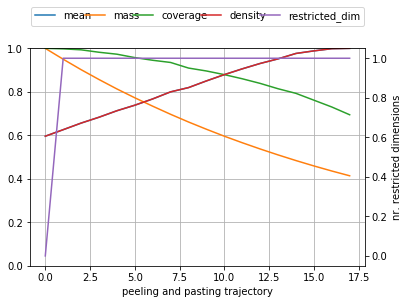

In [18]:
box_1.show_ppt()
plt.show()

coverage    0.879195
density     0.879195
mass           0.596
mean        0.879195
res dim            1
Name: 10, dtype: object

                                               box 10                        
                                                  min       max     qp values
average payment to income ratio for housing  0.321116  0.499899  4.230256e-78



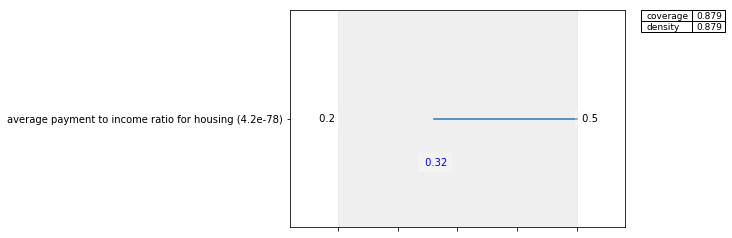

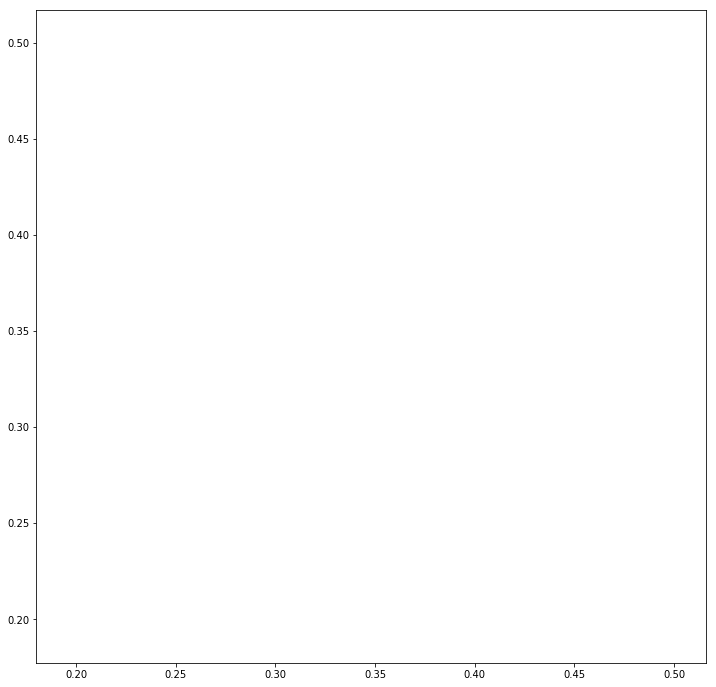

In [15]:
valuebox = 10
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [19]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'People with No Settlements'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>800000] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyNoSettle, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1489 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5666666666666667, coverage: 0.5708529214237743, density: 1.0 restricted_dimensions: 3


In [20]:
box_2.show_tradeoff()
mpld3.display()

TypeError: Object of type 'ndarray' is not JSON serializable

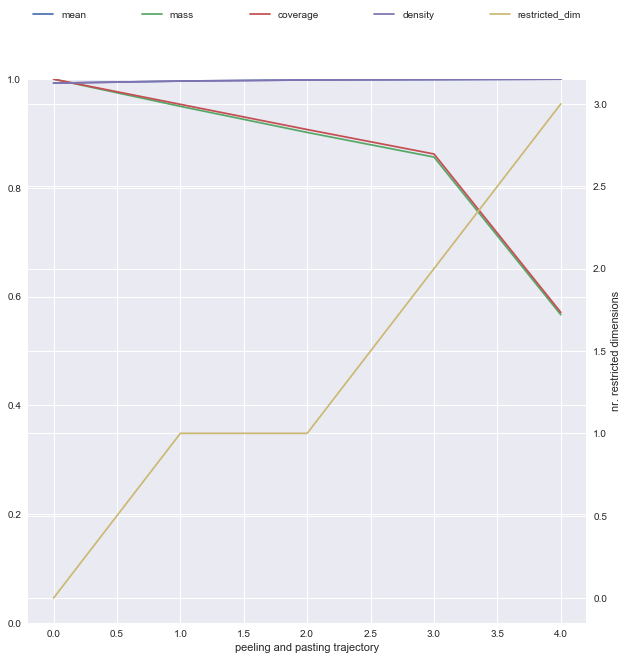

In [22]:
box_2.show_ppt()
plt.show()

coverage    0.862324
density     0.999222
mass        0.856667
mean        0.999222
res dim            2
Name: 3, dtype: object

                                box 3                    
                                  min       max qp values
average Immigration percent  0.014902  0.059994  0.001212
Average Fertility Rate       0.010710  0.024996  0.433707



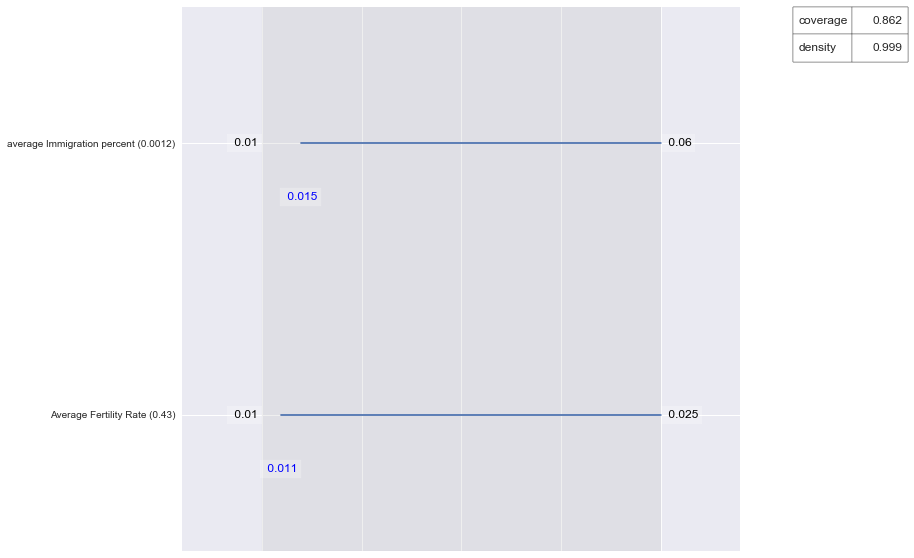

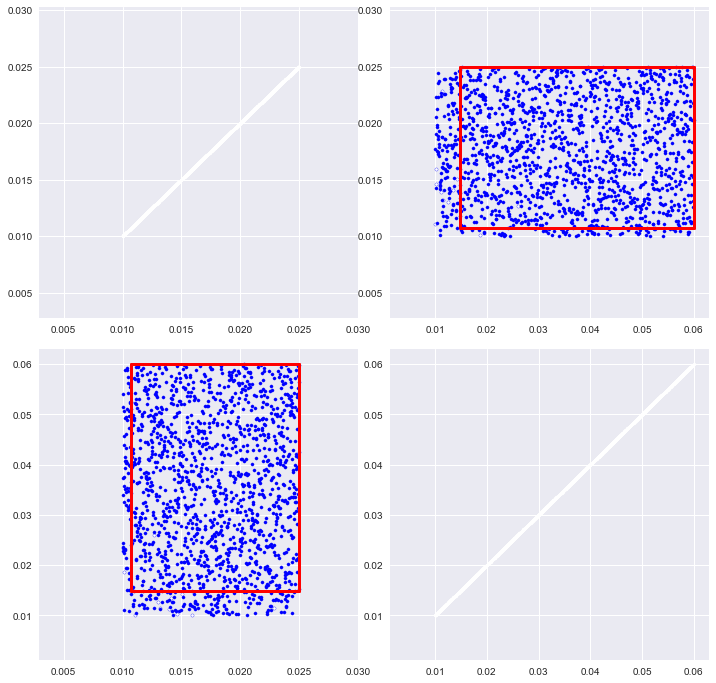

In [23]:
valuebox = 3
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [24]:
def classifyUrbanNon(data):
    ooi = 'Urban Non Residential Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<115] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyUrbanNon, threshold=0.8)
box_4 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1007 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.37266666666666665, coverage: 0.5551142005958292, density: 1.0 restricted_dimensions: 3


In [25]:
box_4.show_tradeoff()
mpld3.display()

coverage    0.836147
density     0.941834
mass           0.596
mean        0.941834
res dim            2
Name: 10, dtype: object

                                 box 10                        
                                    min       max     qp values
average Immigration percent    0.028611  0.059994  3.320323e-82
Base Non Economic Reconv rate  0.011938  0.049988  7.145244e-02



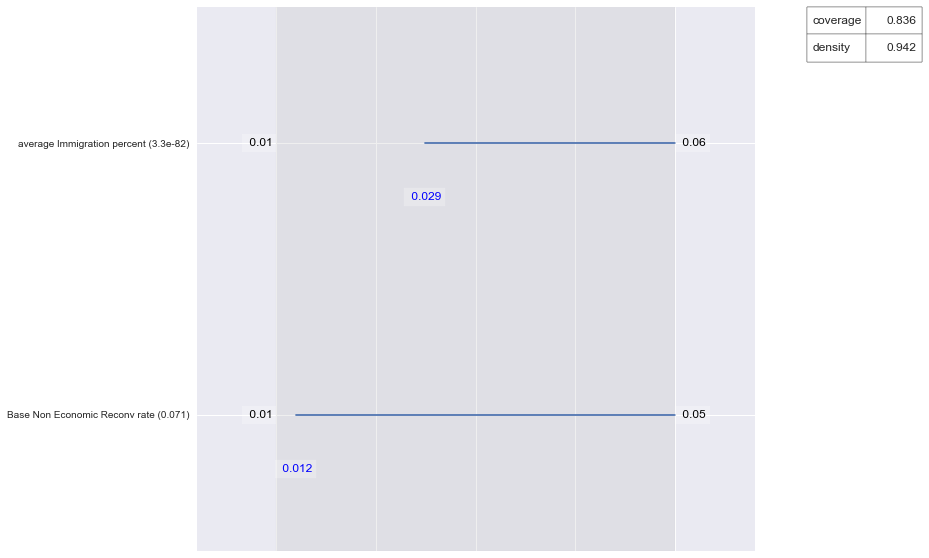

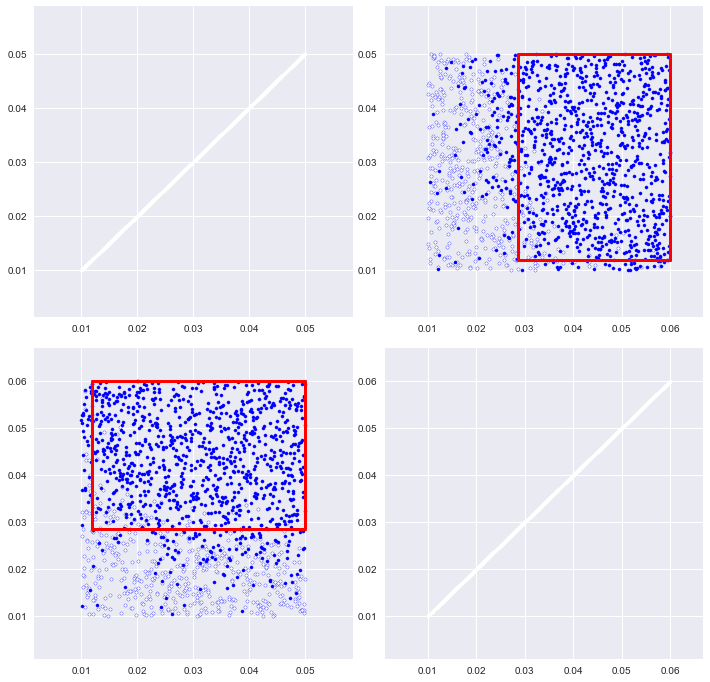

In [26]:
valuebox = 10
box_4.inspect(valuebox)
box_4.select(valuebox)

top_box = valuebox
box_4.inspect(top_box, style='graph')

fig = box_4.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [28]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<6] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyGreenA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1018 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.25866666666666666, coverage: 0.381139489194499, density: 1.0 restricted_dimensions: 4


In [29]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.805501
density     0.870488
mass           0.628
mean        0.870488
res dim            2
Name: 9, dtype: object

                                         box 9                        
                                           min       max     qp values
Base Economic area Conversion rate    0.026943  0.059979  1.025758e-38
Base Green Area commisioned per year  0.020007  0.058099  1.642813e-01



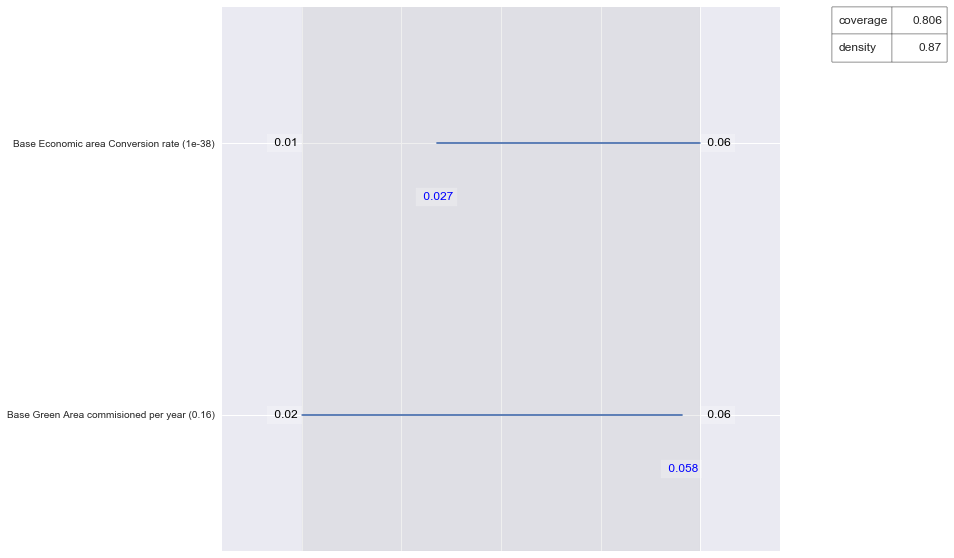

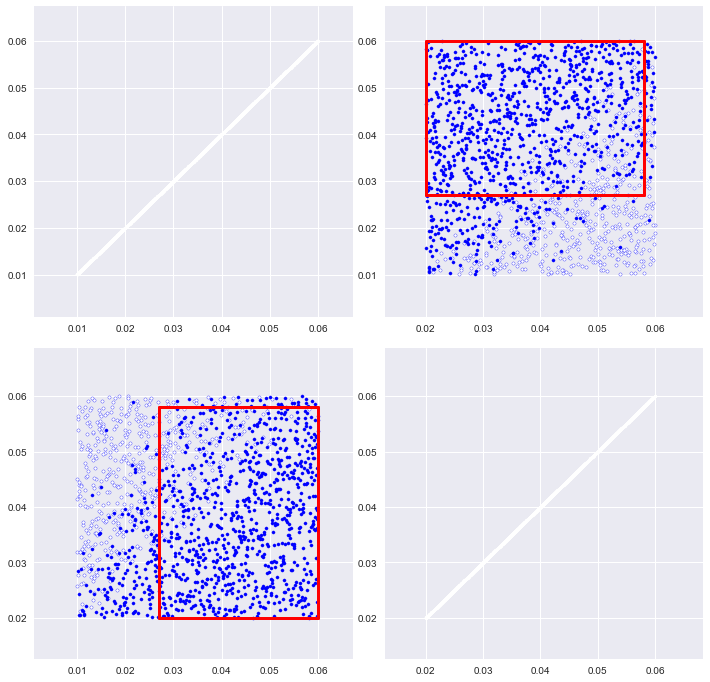

In [30]:
valuebox = 9
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [31]:
def classifySlumPoP(data):
    ooi = 'Illegal Slum Population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome >20000 ] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifySlumPoP, threshold=0.8)
box_6 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1071 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.51, coverage: 0.7142857142857143, density: 1.0 restricted_dimensions: 1


In [32]:
box_6.show_tradeoff()
mpld3.display()

coverage    0.918768
density     0.941627
mass        0.696667
mean        0.941627
res dim            1
Name: 7, dtype: object

                                box 7                        
                                  min       max     qp values
Base Slum reconversion rate  0.010011  0.044834  4.315147e-78



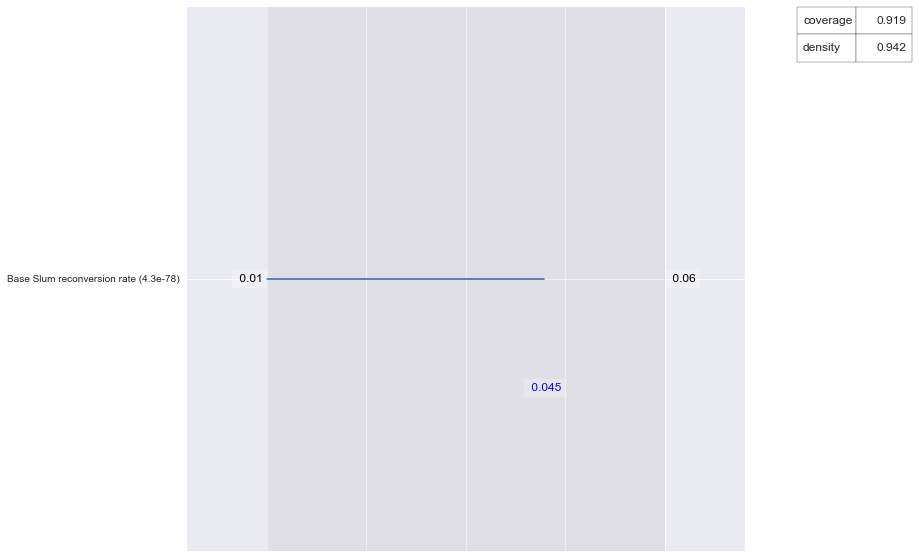

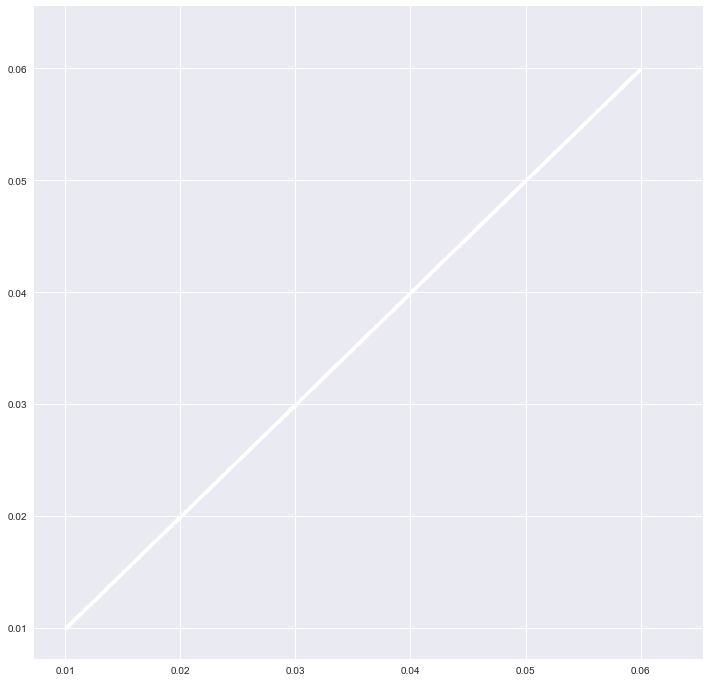

In [33]:
valuebox = 7
box_6.inspect(valuebox)
box_6.select(valuebox)

top_box = valuebox
box_6.inspect(top_box, style='graph')

fig = box_6.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()